In [5]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [85]:
img_test = cv2.imread('data/sudoku_1.jpg')
img_test = cv2.resize(img_test,(282,282))

In [102]:
def preprocess(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.GaussianBlur(img, (5,5), 1)
    img = cv2.adaptiveThreshold(img, maxValue=255, adaptiveMethod=1, thresholdType=1, blockSize=11, C=2)
    return img

pp_img = preprocess(img_test)

In [105]:
def find_countour(img, pp):
    img_contour = img.copy()
    contours = cv2.findContours(pp, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_contour = cv2.drawContours(img_contour, contours[1], -1, (0, 255, 0), 3)
    return contours

cnt = find_countour(img_test, pp_img)

In [106]:
def bigContour(contours):
    big = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 50: #if too small, will find noise
            perimeter = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02*perimeter, True)
            if area > max_area and len(approx)==4: #checking of rect/square
                big = approx
                max_area = area
    return big, max_area

# order of the 4 points should be the same always. reorder() ensures this
def reorder(points):
    points = points.reshape((4,2))
    points_new = np.zeros((4,1,2), dtype=np.int32)
    add = points.sum(1)
    points_new[0] = points[np.argmin(add)]
    points_new[3] =  points[np.argmax(add)]
    diff = np.diff(points, axis=1)
    points_new[1] = points[np.argmin(diff)]
    points_new[2] = points[np.argmax(diff)]
    return points_new

def function(img, contours):
    img_big_contour = img.copy()
    big, max_area = bigContour(contours[1])
    if big.size!=0:
        big = reorder(big)
        img_big_contour = cv2.drawContours(img_big_contour, big, -1, (255,255,0), 20) #draw the biggest contour
        # preapres points for warp
        pts1 = np.float32(big) 
        pts2 = np.float32([[0,0], [252,0], [0,252], [252, 252]])
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        warped_img = cv2.warpPerspective(img, matrix, (252, 252))
        warped_img = cv2.cvtColor(img_test, cv2.COLOR_RGB2GRAY)
        return warped_img
    
warped = function(img_test, cnt)

In [107]:
warped

array([[ 26,  19,   8, ...,   5,  14,  25],
       [ 19,  50,  87, ...,  95,  59,  19],
       [  8,  78, 157, ..., 171,  96,   8],
       ...,
       [  9,  74, 148, ..., 158,  89,   8],
       [ 19,  44,  74, ...,  79,  50,  19],
       [ 25,  19,   8, ...,   9,  19,  25]], dtype=uint8)

In [89]:
def split_boxes(image):
    rows = np.vsplit(image, 9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r, 9)
        for box in cols:
            boxes.append(box)
    return boxes

In [92]:
def postprocess(image):
    for i,img in enumerate(image):
        mean = np.mean(img)
        std = np.std(img)
        image[i] = (img-mean)/std
    return image
post_img = postprocess(warped)

In [95]:
post_img

array([[8, 5, 0, ..., 0, 3, 6],
       [3, 3, 3, ..., 0, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       ...,
       [3, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [6, 4, 1, ..., 1, 4, 6]], dtype=uint8)

In [90]:

    boxes = split_boxes(image)
    
    for i in range(len(boxes)):
        for j in range(len(boxes[i])):
            boxes[i][j][0]=0
            boxes[i][j][-1]=0      
    
    nums = np.array([1 if np.sum(boxes[i].flatten())/(255*81)>0.5 else 0 for i in range(len(boxes))])
    
    return nums

In [91]:
postprocess(warped)

ValueError: array split does not result in an equal division

In [22]:
# plt.title('Sample')
# plt.imshow(warped_sudoku)
# plt.show()
# plt.title('Box')
# plt.imshow(boxes[0])
# plt.show()

In [19]:
np.shape(boxes)

(81, 28, 28)

In [20]:
from tensorflow import keras
from keras.models import load_model
model = load_model('model.h5')
boxes = np.reshape(boxes, (-1,28,28,1))
predicted_numbers = model.predict_classes(boxes)

C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passi

[[9 0 0 0 1 0 0 0 2]
 [4 1 0 0 6 3 0 0 9]
 [0 3 2 0 0 4 6 0 0]
 [0 0 0 3 4 0 0 0 0]
 [0 2 8 0 0 0 0 0 0]
 [0 0 0 5 2 0 0 0 0]
 [0 8 1 0 0 5 3 0 0]
 [2 7 0 0 3 1 0 0 5]
 [5 0 0 0 8 0 0 0 4]]


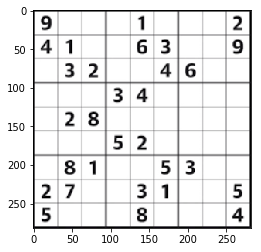

In [21]:
print(np.reshape(predicted_numbers*np.array(nums),(9,9)))
plt.show()
plt.imshow(sudoku)
plt.show()

In [22]:
cap = cv2.VideoCapture(1)

while cap.isOpened():
    start_time = time.time()
    ret, frame = cap.read()
    processedFrame = preprocess(frame)
    biggest = find_largest_contour(processedFrame)
    try:
        coords = get_corners(biggest)
        if validate_rect(coords):   
            #for i in range(4):
            #    cv2.circle(frame, (int(coords[i][0]), int(coords[i][1])), 5, (0,0,255), -1)  
            cv2.drawContours(frame, [biggest], 0, (0,255,0), 2)

            warped = perspective_transform(coords, frame)
            warped_binary = preprocess(warped)
            warped_inv = cv2.bitwise_not(warped_binary)
            if not validation:
                sudoku_matrix = extract_digit(warped_inv)
                unsolved = sudoku_matrix.copy()
                if isValidConfig(sudoku_matrix) and np.count_nonzero(sudoku_matrix)!=0:
                    validation = True
                    sudoku_matrix, solve_time = solve_wrapper(sudoku_matrix)
            solved_grid_image = fill_sudoku(sudoku_matrix, unsolved, warped)
            frame = unwarp_image(solved_grid_image, frame, coords)

    except :
        pass

    # used to calculate the fps
    fps = int ( 1/ (time.time() -start_time) ) 
    fps = str(fps) 
    cv2.putText(frame, fps, (7, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)
    cv2.imshow('live', frame)

    #exit if q is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()        
cv2.destroyAllWindows()